In [1]:
import glob
import os
import numpy as np
from sklearn import linear_model, metrics
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from GoogletNet import GoogLeNet
from SISE import SISE
from sklearn.linear_model import Ridge

In [2]:
# 이미지 불러오기 및 전처리
def load_and_preprocess_images(img_paths, target_size=(224,224)):
    img_array_list = []
    for img_path in img_paths:
        img = np.array(Image.open(tf.io.gfile.GFile(img_path,'rb')).convert('RGB').resize(target_size, Image.BILINEAR), dtype=np.float32)
        img = img / 255.0
        img = np.expand_dims(img, axis=0)
        img_array_list.append(img)
    return np.vstack(img_array_list)

def create_cav_training_set(concepts, bottleneck, acts):
    x = []
    labels = []
    labels2text = {}
    min_data_points = np.min([acts[concept][bottleneck].shape[0] for concept in acts.keys()])

    for I, concept in enumerate(concepts):
        x.extend(acts[concept][bottleneck][:min_data_points].reshape(min_data_points, -1))
        labels.extend([I] * min_data_points)
        labels2text[I] = concept
    
    x = np.array(x)
    labels = np.array(labels)

    return x, labels, labels2text

def train_lm(lm, x, y, labels2text):
    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=0.33, stratify=y)
    
    lm.fit(x_train, y_train)
    y_pred = lm.predict(x_test)
    
    num_classes = max(y) + 1
    acc = {}
    num_correct = 0
    for class_id in range(num_classes):
        # get indices of all test data that has this class.
        idx = (y_test == class_id)
        acc[labels2text[class_id]] = metrics.accuracy_score(
          y_pred[idx], y_test[idx])
        # overall correctness is weighted by the number of examples in this class.
        num_correct += (sum(idx) * acc[labels2text[class_id]])
    acc['overall'] = float(num_correct) / float(len(y_test))
    tf.compat.v1.logging.info('acc per class %s' % (str(acc)))
    return acc

In [3]:
model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=True)
layer_names = ['mixed8', 'mixed9', 'mixed10']
target_class_names = ['zebra']
concept_names = ['striped']
random_concept_names = ['random1', 'random2', 'random3']
concept_pairs = []

for c in concept_names:
    for rc in random_concept_names:
        concept_pairs.append([c, rc])

layer_outputs = [model.get_layer(name).output for name in layer_names]
activation_model = Model(inputs=model.input, outputs=layer_outputs)

InceptionV3
- (9) activation_2 - 64
- (16) activation_4 - 192
- (86) mixed2 - 288
- (228) mixed7 - 768
- (310) mixed10 - 2048

레이어 선택 기준: 피쳐의 크기가 감소하기 전의 레이어 선택
- InceptionV3 모델의 경우는 피쳐맵 하나에서 여러개의 분기로 나눠져 따로 다운 샘플링 되기 때문에 크기가 감소하기 전 concat 레이어를 선택함

In [4]:
# 레이어 이름과 인덱스 출력
for i, layer in enumerate(model.layers):
    if 'mixed' in layer.name:
        print(f"{layer.name} - {i}")

mixed0 - 40
mixed1 - 63
mixed2 - 86
mixed3 - 100
mixed4 - 132
mixed5 - 164
mixed6 - 196
mixed7 - 228
mixed8 - 248
mixed9_0 - 276
mixed9 - 279
mixed9_1 - 307
mixed10 - 310


In [5]:
sise = SISE(model, 'inceptionv3', 'test.jpg', 340, img_size=(299, 299), detail=1)
sise.feature_extractor()
sise.feature_filtering()
sise.postprocess()
# sise.generate_layer_visualization_map()
# sise.layers_fusion()

64 -> 28, 36개 감소 (감소율: -56.25%)
192 -> 88, 104개 감소 (감소율: -54.166666666666664%)
288 -> 170, 118개 감소 (감소율: -40.97222222222222%)
768 -> 372, 396개 감소 (감소율: -51.5625%)
2048 -> 883, 1165개 감소 (감소율: -56.884765625%)

Total
3360 -> 1541, 1819개 감소 (감소율: -54.13690476190476%)


In [6]:
# plt.imshow(sise.img)
# plt.imshow(sise.result, cmap='jet', alpha=0.5)
# plt.colorbar()
# plt.show()

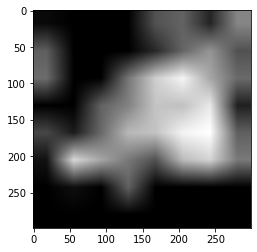

In [8]:
plt.imshow(sise.postprocessed_feature_maps['conv4'][:,:,30], cmap='gray')